In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [138]:
# DFs einlesen
df_training_all_features = pd.read_parquet(
    "../data/processed/df_training_all_features.parquet"
)
df_test_all_features = pd.read_parquet(
    "../data/processed/df_test_all_features.parquet"
)

In [139]:
# Globales DataFrame zur Speicherung der Ergebnisse
results_df = pd.DataFrame(columns=["Durchlauf", "Modell", "Accuracy", "F1 Score"])

def log_model_performance(durchlauf_name: str, model_name: str, y_pred, y_test):
    """
    Berechnet Accuracy und F1-Score anhand von y_test und y_pred und
    fügt die Ergebnisse dem globalen DataFrame results_df hinzu.
    
    Parameter:
      - durchlauf_name: Name des Durchlaufs (String)
      - model_name: Name des verwendeten Modells (String)
      - y_pred: Vorhersagen des Modells
      - y_test: Wahre Zielwerte
      
    Gibt zurück:
      - Das aktualisierte DataFrame mit den Spalten "Durchlauf", "Modell", "Accuracy" und "F1 Score"
    """
    global results_df
    # Berechnung der Metriken
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Neuen Eintrag als DataFrame erstellen
    new_row = pd.DataFrame({
        "Durchlauf": [durchlauf_name],
        "Modell": [model_name],
        "Accuracy": [acc],
        "F1 Score": [f1]
    })
    
    # Ergebnisse zum globalen DataFrame hinzufügen
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    return results_df

# Antoninos Teil (Naive Bayes & NN/DL)

## Naive Bayes

wie kann man besten die Spalten handlen: _min_mx, _standardisiert, _normalverteilt

In [140]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [141]:
df_training_all_features#.loc[:, :'Support_per_Year']

,Age of customer,Sex,Ctry,Town,Swimming Hours per Week,Biking Hours per Week,Running Hours per Week,Total Training Hours per Week,VO2 Max,10k Running Time Prediction,Calories Burned per Week,Support Cases of Customer,Customer Years,Goal of Training,Preferred Training Daytime,Subscription Type,Synchronisation,User of latest model,Days since Update,Training Efficiency,Support_per_Year,Training Efficiency Normalver.,Swimming Hours per Week Normalver.,Biking Hours per Week Normalver.,Running Hours per Week Normalver.,Total Training Hours per Week Normalver.,VO2 Max Normalver.,10k Running Time Prediction Normalver.,Calories Burned per Week Normalver.,Days since Update Normalver.,Training Efficiency Standardisiert,Swimming Hours per Week Standardisiert,Biking Hours per Week Standardisiert,Running Hours per Week Standardisiert,Total Training Hours per Week Standardisiert,VO2 Max Standardisiert,10k Running Time Prediction Standardisiert,Calories Burned per Week Standardisiert,Days since Update Standardisiert,Training Efficiency Min_Max,Swimming Hours per Week Min_Max,Biking Hours per Week Min_Max,Running Hours per Week Min_Max,Total Training Hours per Week Min_Max,VO2 Max Min_Max,10k Running Time Prediction Min_Max,Calories Burned per Week Min_Max,Days since Update Min_Max,Town target encoded,Goal of Training target encoded,Subscription Type target encoded,Support Cases of Customer target encoded,Customer Years target encoded,Subscription Type Ordinal,Age of customer Bin
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C0001,61.0,Other,UK,Birmingham,2.52,0.10,1.78,4.40,23.08,60.72,2329.950000,2.0,1.0,Fitness,Evening,Free,Yes,1.0,213.0,529.534091,1,1.350827,0.348654,-1.988575,-0.599666,-1.499818,-1.625392,1.706251,-1.322831,-0.316162,0.594527,0.182082,-1.545832,-0.685104,-1.335981,-1.993361,2.013199,-1.262634,-0.444098,0.837587,0.252758,0.006207,0.149958,0.162152,0.182878,0.832894,0.178371,0.363839,0.304348,0.345238,0.361765,0.423077,0.565217,1,9
C0003,57.0,Other,Australia,Sydney,1.55,10.01,4.57,16.13,39.04,54.37,7904.930000,2.0,1.0,Fitness,Evening,Premium,Yes,0.0,285.0,490.076255,1,-0.519453,-0.280694,1.212113,0.699531,1.035341,-0.795943,1.032418,0.975890,0.091219,-0.139736,-0.426412,1.274837,0.600577,1.028567,-0.813458,1.169522,0.969956,0.114413,0.798457,0.155466,0.621353,0.385004,0.609691,0.409841,0.665525,0.596683,0.524554,0.383333,0.345238,0.480363,0.423077,0.565217,3,8
C0004,30.0,Other,India,Bangalore,1.19,12.04,8.64,21.87,71.59,33.92,10839.810000,2.0,0.0,Competition,Afternoon,Free,Yes,1.0,188.0,495.647462,4,-0.243948,-0.557358,1.620398,2.003915,1.901768,2.346735,-1.952642,1.962428,-0.472470,-0.036063,-0.652244,1.852632,2.476105,2.185643,1.592921,-1.547515,2.145275,-0.638026,0.803982,0.119358,0.747362,0.727885,0.828691,0.872725,0.126516,0.816899,0.308036,0.265625,0.590759,0.361765,0.423077,0.540541,1,2
C0005,21.0,Male,Germany,Munich,2.25,4.67,0.92,7.84,49.09,44.97,3958.160897,3.0,0.0,Recreation,Evening,Premium,No,1.0,193.0,504.867461,4,0.191985,0.187150,-0.099782,-1.160985,-0.574142,-0.338025,0.160894,-0.557832,-0.441090,0.135511,0.012708,-0.245079,-1.081408,-0.642542,-0.070475,-0.079385,-0.610591,-0.599240,0.813125,0.225677,0.289882,0.077506,0.293399,0.552759,0.417765,0.300542,0.319196,0.366667,0.325301,0.480363,0.437186,0.540541,3,0
C0006,63.0,Male,India,Mumbai,0.80,5.88,0.67,7.35,13.91,62.46,3575.960000,3.0,3.0,Recreation,Morning,Basic,Yes,0.0,94.0,486.525170,0,-0.716604,-0.895779,0.239774,-1.352452,-0.691929,-2.537509,1.919875,-0.727066,-1.280125,-0.205817,-0.896897,0.099321,-1.196612,-0.741317,-2.671287,2.244380,-0.763649,-1.367193,0.794935,0.080241,0.364991,0.056445,0.274704,0.052474,0.878756,0.271864,0.098214,0.271186,0.325301,0.403333,0.437186,0.376147,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0996,28.0,Female,Australia,Brisbane,

In [142]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
def encode_categorical_features(X_train, X_test, categorical_features):
    if categorical_features:
        X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
        X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
        # Sicherstellen, dass beide DataFrames die gleichen Spalten haben
        X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)
    return X_train, X_test


In [144]:
from sklearn.naive_bayes import GaussianNB

# Liste der kategorialen Spalten
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Entferne die kategorialen Spalten aus dem DataFrame
df_training_numeric_only = df_training_all_features.drop(columns=categorical_cols)

# Wähle die Zielvariable aus (hier muss die Spalte mit der Zielvariable eingefügt werden)
target_column = "User of latest model"  # Hier den Namen der Zielvariablen einfügen
X = df_training_numeric_only.drop(columns=[target_column])
y = df_training_numeric_only[target_column]

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Modell trainieren
baseline_model = GaussianNB()
baseline_model.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred_baseline = baseline_model.predict(X_test)

# Ergebnisse loggen
df_results = log_model_performance("Baseline mit allen Spalten, ohne kategoriale", "Naive Bayes", y_pred_baseline, y_test)
df_results

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_70349/1598733018.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Durchlauf,Modell,Accuracy,F1 Score
0,"Baseline mit allen Spalten, ohne kategoriale",Naive Bayes,0.774359,0.721519


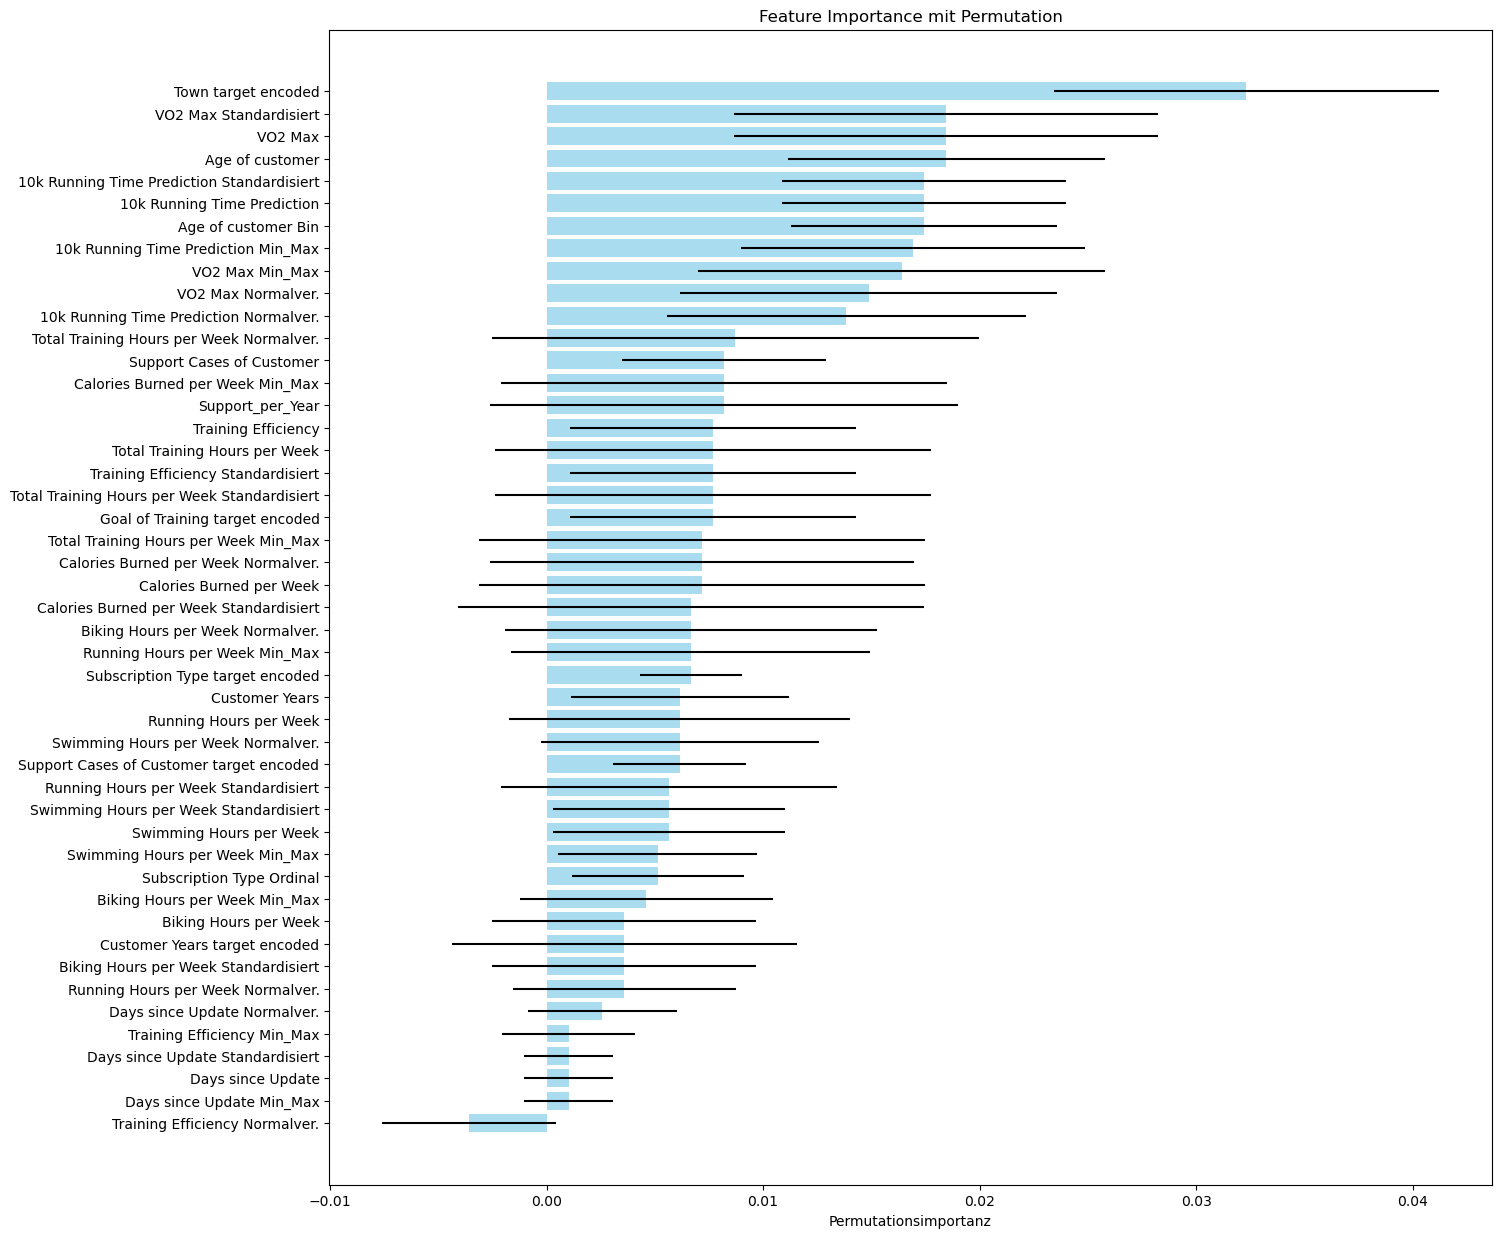

In [145]:
from sklearn.inspection import permutation_importance

# Dein trainiertes Naive Bayes Modell
model = baseline_model

# Berechne die Permutationsimportanz auf den Testdaten
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Hole die Durchschnittswerte und Standardabweichungen der Importanz
importances = result.importances_mean
importances_std = result.importances_std

# Erstelle einen DataFrame mit den Ergebnissen
feature_names = X_test.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances,
    "Std": importances_std
}).sort_values(by="Importance", ascending=False)

# Visualisierung der Feature Importance
plt.figure(figsize=(15, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], xerr=importance_df["Std"], color="skyblue", alpha=0.7)
plt.xlabel("Permutationsimportanz")
plt.title("Feature Importance mit Permutation")
plt.gca().invert_yaxis()  # Damit die wichtigsten Features oben sind
plt.show()

In [146]:
features_to_remove = importance_df[importance_df["Importance"] < 0.005]["Feature"].tolist()  # Schwellwert kann angepasst werden

# Least important Features aus dem DataFrame entfernen
df_training_selected_features = df_training_numeric_only.drop(columns=features_to_remove + [target_column])

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(df_training_selected_features, df_training_numeric_only[target_column], test_size=0.2, random_state=42)

# Modell erneut trainieren
model = GaussianNB()
model.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

# Ergebnisse loggen
df_results = log_model_performance("Featureimportance > 0.005", "Naive Bayes", y_pred, y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,"Baseline mit allen Spalten, ohne kategoriale",Naive Bayes,0.774359,0.721519
1,Featureimportance > 0.005,Naive Bayes,0.779487,0.736196


In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Dein trainiertes Naive Bayes Modell
X = df_training_selected_features  # numerische Features
y = df_training_all_features[target_column]  # Zielvariable

# Parametergrid für GridSearchCV
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6],  # Werte für var_smoothing
    'priors': [None] + [[i/float(len(y)-1) for i in range(len(y))] for _ in range(len(y))]  # Priors für jede Klasse
}

# GridSearchCV Objekt erstellen
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, verbose=1)

# GridSearchCV anwenden
grid_search.fit(X, y)

# Bestes Modell und seine Hyperparameter
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Beste Hyperparameter: {best_params}")
print(f"Beste Leistung: {grid_search.best_score_}")

# Evaluiere das beste Modell auf dem Testdatensatz
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Logge die Ergebnisse
df_results = log_model_performance("Hyperparameter-Tuning", "Naive Bayes", y_pred, y_test)
df_results

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Beste Hyperparameter: {'priors': None, 'var_smoothing': 1e-08}
Beste Leistung: 0.7311710282844304


/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
19420 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19420 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anacond

,Durchlauf,Modell,Accuracy,F1 Score
0,"Baseline mit allen Spalten, ohne kategoriale",Naive Bayes,0.774359,0.721519
1,Featureimportance > 0.005,Naive Bayes,0.779487,0.736196
2,Hyperparameter-Tuning,Naive Bayes,0.758974,0.715152


### Multinomial

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Liste der kategorialen Spalten
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Identifiziere die numerischen Features
numerical_cols = df_training_all_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

# Wähle die Zielvariable aus (hier muss die Spalte mit der Zielvariable eingefügt werden)
target_column = "User of latest model"  # Hier den Namen der Zielvariablen einfügen

# Entferne die kategorialen Spalten aus dem DataFrame
df_training_numeric_only = df_training_all_features.drop(columns=categorical_cols + [target_column])

# Wähle die Zielvariable aus
X = df_training_numeric_only
y = df_training_all_features[target_column]


# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Baseline Modell trainieren
baseline_model = MultinomialNB()
baseline_model.fit(X_train_scaled, y_train)

# Vorhersagen auf den Testdaten
y_pred_baseline = baseline_model.predict(X_test)
df_results = log_model_performance("Baseline mit allen numerischen Spalten", "Multinomial Naive Bayes", y_pred_baseline, y_test)
df_results

/Applications/anaconda3/envs/intro_ds_ai/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,"Baseline mit allen Spalten, ohne kategoriale",Naive Bayes,0.774359,0.721519
1,Featureimportance > 0.005,Naive Bayes,0.779487,0.736196
2,Hyperparameter-Tuning,Naive Bayes,0.758974,0.715152
3,Baseline mit allen numerischen Spalten,Multinomial Naive Bayes,0.435897,0.604317


kein Sinn hier weiter zumachen